In [ ]:
import os
os.chdir('/Coding/CVPR2025_abaw_framewise/')

In [2]:
import os
import sys
import math
import time
import torch
import shutil
import pickle
import audiomentations

from dataclasses import dataclass
from torch.utils.data import DataLoader
from transformers import AutoTokenizer


from abaw.model import Model
from abaw.trainer import train
from abaw.evaluate import evaluate
from abaw.utils import setup_system, Logger
from abaw.abaw_dataset import HumeDatasetEval, HumeDatasetTrain, SpecialTokens
from abaw.transforms import get_transforms_train, get_transforms_val, get_transforms_train_wave, get_transforms_train_wave_custom

@dataclass
class Configuration:
    model: tuple = ('linear',
                    'audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim',
                    'Alibaba-NLP/gte-en-mlm-base',)  # 'bert-base-uncased'

    text_context_width_s: float = 24.0 
    wave_length_s: float = 6.0
    eval_fps: float = 0.3          # An evaluation is conducted every X seconds during the given samples. X = eval_fps
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Training 
    batch_size: int = 32
    gpu_ids: tuple = (0,1,2,3)  # GPU ids for training

    # Text-Augmentations
    enable_text_augs = False
    prob_synonym = 0                # 0.01  # prob_synonym
    prob_deletion = 0               # 0.01  # prob_deletion  
    prob_swap = 0                   # 0.00  # prob_swap
    prob_bert = 0                   # 0.025 # prob_bert

    enable_custom_sound_augs = False
    custom_sound_augs = [
        audiomentations.AddGaussianNoise(min_amplitude=0.025, max_amplitude=0.25, p=0.6),  # BEST -> 0.5065
        audiomentations.TimeStretch(min_rate=0.95, max_rate=1.05, p=0.5),                  # BEST -> 0.5065 (unverändert)
        audiomentations.PitchShift(min_semitones=-2, max_semitones=2, p=0.5),              # BEST -> 0.5065 (unverändert)
        audiomentations.Shift(min_shift=-0.1, max_shift=0.1, p=0.5),                       # BEST -> 0.5065 (unverändert)
    ]

    # Eval
    batch_size_eval: int = 32
    eval_every_n_epoch: int = 1  # eval every n Epoch

    # Dataset
    data_folder:str = "./data_abaw/"
    fps:float = 24
    sr:float = 16 * 1e3
    # -> within mp4 => 24 FPS

    # set num_workers to 0 if on Windows
    num_workers: int = 0 if os.name == 'nt' else 4

config = Configuration()

# Dataloader

processor_text = AutoTokenizer.from_pretrained(config.model[2])
processor_text.add_special_tokens(SpecialTokens.generate_special_token_dict())

# Train
train_dataset = HumeDatasetTrain(data_folder=config.data_folder,
                                    label_file_csv=f"data_abaw/splits/train.csv",
                                    model=config.model,
                                    sr=config.sr,
                                    fps=config.fps,
                                    wave_length_s=config.wave_length_s,
                                    wave_transforms=get_transforms_train_wave() if not config.enable_custom_sound_augs else get_transforms_train_wave_custom(config.custom_sound_augs),
                                    enable_text_augs=config.enable_text_augs,
                                    text_context_width_s=config.text_context_width_s,
                                    config=config,
                                    processor_text=processor_text,
                                    )

train_dataloader = DataLoader(train_dataset,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers,
                                shuffle=False,
                                pin_memory=True,
                                collate_fn=train_dataset.collate_fn
                                )

# Eval
eval_dataset = HumeDatasetEval(data_folder=config.data_folder,
                                label_file_csv=f"data_abaw/splits/val.csv",
                                model=config.model,
                                sr=config.sr,
                                fps=config.fps,
                                wave_length_s=config.wave_length_s,
                                text_context_width_s=config.text_context_width_s,
                                processor_text=processor_text,
                                )

eval_dataloader = DataLoader(eval_dataset,
                                batch_size=config.batch_size_eval,
                                num_workers=config.num_workers,
                                shuffle=False,
                                pin_memory=True,
                                collate_fn=eval_dataset.collate_fn
                                )

print("Train Length:", len(train_dataset))
print("Val Length:", len(eval_dataset))


/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home//j0kr0017/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home//j0kr0017/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home//j0kr0017/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home//j0kr0017/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Train Length: 1006
Val Length: 1345


In [3]:
# train
index = 6 

audio, vision, text, label_id, avg, s, t, idx = train_dataset[index]

# Display the type and shape of audio
print(f"Audio Type: {type(audio)}")
if hasattr(audio, "shape"):  # For NumPy arrays, PyTorch tensors, etc.
    print(f"Audio Shape: {audio.shape}")
else:
    print("Audio data:", audio)  # Fallback for other types

# Print text data
print(f"Text A: {text}")

print(f"Text A: {label_id}")

print(f"Text A: {s}")

print(f"Text A: {t}")

print(f"Text A: {idx}")


Audio Type: <class 'numpy.ndarray'>
Audio Shape: (96000,)
Text A: I am willing to play Omi the card game every time I'm almost always feeling to do that [ATTENTION] with my friends or at home with others because I like the game so much and it gives some you to excitement
Text A: 0.0
Text A: 147813.0
Text A: 9.238312721252441
Text A: 6.0


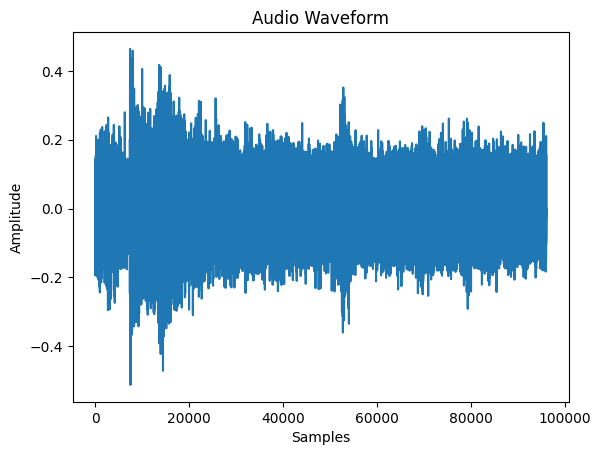

In [4]:
import matplotlib.pyplot as plt

plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [17]:
# ATT-TOKEN == 30522

idx=24

batch = next(iter(train_dataloader))
audio, vision, text, att_pos, label_id, avg, s, t, p = batch

#print("Audio:", audio)
#print("Vision:", vision)
print("Attention Positions:", att_pos[idx])
print("Label ID:", label_id[idx])
#print("Average:", avg)
print("s:", s[idx])
print("t:", t[idx])
print("p:", p[idx])

decoded_text = processor_text.decode(text["input_ids"][idx])
print(text["input_ids"][idx])
print("Text:", decoded_text)
#print("Text:", processor_text.decode(text[idx]))


Attention Positions: tensor(36)
Label ID: tensor(0.)
s: tensor(522501.)
t: tensor(32.6563)
p: tensor(24.)
tensor([  101,  2008,  1010,  3398,  1012,  2021,  2112,  1997,  2893,  2870,
         2000,  2175,  2041,  1999,  2270,  1010,  2009,  2965,  1045,  2031,
         2000,  2785,  1997,  2131,  2870,  3201,  1012,  2061,  3398,  1010,
         1045,  2572,  2074,  2025,  2412,  2031, 30522,  2042,  1996,  2828,
         1997,  2711,  2040,  2097,  4929,  2026, 27621,  2012,  1996,  6670,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Text: [CLS] that, yeah. but part of gettin

In [6]:
# train
index = 15

audio, vision, text, label_id, s, t, idx = eval_dataset[index]

# Display the type and shape of audio
print(f"Audio Type: {type(audio)}")
if hasattr(audio, "shape"):  # For NumPy arrays, PyTorch tensors, etc.
    print(f"Audio Shape: {audio.shape}")
else:
    print("Audio data:", audio)  # Fallback for other types

# Print text data
print(f"Text A: {text}")

print(f"Text A: {label_id}")

print(f"Text A: {s}")

print(f"Text A: {t}")

print(f"Text A: {idx}")

text:  she needs it. She's starving, of course. and so I'll get up head to the kitchen and then go to the cupboard grab her food out of there use the scoop put that in her bowl and then I'll check to [ATTENTION] see how the water is doing and then once I do that if it needs refilling I will fill a cup and put some more water into her bowl and that's one of the things that I do usually right away when
sound_index:  609333
frame_index:  914
time_point:  38.0833125
general_path:  82688/Visite_1/82688_Question_1_2024-11-14_13-50-17_Video.mp4/82688_Question_1_2024-11-14_13-50-17_Video
class_id:  0
Audio Type: <class 'numpy.ndarray'>
Audio Shape: (96000,)
Text A: she needs it. She's starving, of course. and so I'll get up head to the kitchen and then go to the cupboard grab her food out of there use the scoop put that in her bowl and then I'll check to [ATTENTION] see how the water is doing and then once I do that if it needs refilling I will fill a cup and put some more water into her bowl 

In [15]:
# ATT-TOKEN == 30522

idx=31

#it = iter(eval_dataloader)

#batch = next(it)
#audio, vision, text, att_pos, label_id, s, t, p = batch

#print("Audio:", audio)
#print("Vision:", vision)
print("Attention Positions:", att_pos[idx])
print("Label ID:", label_id[idx])
#print("Average:", avg)
print("s:", s[idx])
print("t:", t[idx])
print("p:", p[idx])

decoded_text = processor_text.decode(text["input_ids"][idx])
print(text["input_ids"][idx])
print("Text:", decoded_text)
#print("Text:", processor_text.decode(text[idx]))


Attention Positions: tensor(62)
Label ID: tensor(0.)
s: tensor(550000.)
t: tensor(34.3750)
p: tensor(63.)
tensor([  101,  2115,  4550,  4933,  1998,  2059,  2431,  1996,  2060,  4933,
         2003,  1999,  1996, 14533,  8026,  1998,  2059,  2017,  2123,  1005,
         1056,  2031,  2438,  2282,  2000,  2404,  2009,  2067,  1012,  1998,
         2009,  1005,  1055,  2036,  2107,  1037,  4450,  6313,  2832,  1012,
         1045,  2514,  2066,  2009,  2074,  4515,  2039,  2635,  2061,  2146,
         2138,  2017,  2031,  2000, 10671,  2673,  2030,  6865,  2068,  2039,
         2006,  1996, 30522,  6865,  2545,  1012,  2059,  2017,  2031,  2000,
         3275,  2041,  2073,  2017,  2215,  2000,  2404,  2009,  1012,  1998,
         2059,  2054,  2065,  2017,  2123,  1005,  1056,  2031,  2438,  6865,
         2545,  2030,  2686,  2000,  2404,  2477,  1029,  1998,  2061,  2009,
         2074,  4515,  2039,  3352,  2023,  2428,  4450,  6313,  2832,  1012,
         1998,  2043,  2009,  3310, 